# Qiskit: Variational Quantum Eigensolver for $H_2$

In this notebook, we are going to implement the variational quantum eigensolver (VQE) algorithm to compute the ground energy of molecular hydrogen $H_2$. This is one of the smallest systems one can imagine to start experimenting with in VQE. It has also been implemented on an actual quantum computer as reported in [O'Malley etal 2015, *Scalable Quantum Simulation of Molecular Energies*, arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860). The following figure given in the article summarizes the entire setup:

![Fig. 1. The variational quantum eigensolver circuit and hardware. Source: arXiv:1512.06860v2](omalley-etal-2015-vqe.png)

In this session, we are going to implement the VQE algorithm for $H_2$ from scratch using the circuit in the figure and the data given in the paper.

## Synopsis

Before we begin, let us summarize the task ahead of us, and what exactly we are going to do. Remember that VQE starts with classical preparations, this involves classical computational chemistry computations. As a result of these preparations we have the qubit Hamiltonian and the ansatz circuit that represents the parameterized unitary. We assume that all this work has been completed: the result is the ansatz circuit and the Hamiltonian shown in the figure above.

Let us summarize the computation shown in the figure.

The algorithm consists of two parts. Firstly, there is a computation carried out on a quantum computer. This is divided into three parts in the figure, (1) Prepare initial state, (2) Apply Parameterized Ansatz, (3) Measure Expectation values. The entire quantum computation is performed using the circuit shown at the bottom part, 'Software'. Note the circuit contains only two qubits.

Secondly, there is the classical part, comprising (1) Calculate Energy and (2) Classical Optimizer Suggests New Parameters $\theta$. The qubit Hamiltonian of $H_2$ is also shown on the right. 

Note that the top part of the figure also shows a rough outline of physical pulses with timings that are needed to run the circuit.

We will implement both the classical and quantum parts in Python using Qiskit. We will implement the algorithm from scratch *without* using the more advanced Qiskit libraries. We will only rely circuits and measurements. In principle, we will show how to implement the algorithm in *any language that contains circuits and measurements*.

The rationale of showing this simple, low level implementation is to give a taste of what is going on behind the scenes of the more advanced (Qiskit) libraries.

## Implementation

Let us start by creating a routine for the circuit in the figure.

In [3]:
import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator

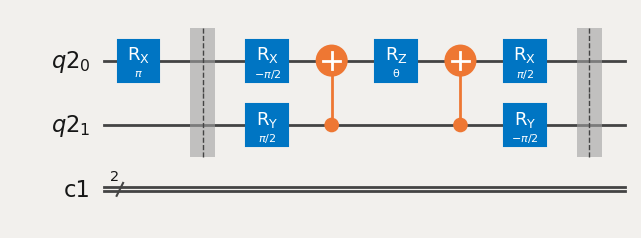

In [4]:
simulator = AerSimulator()


##########################################################
#
#  Routines
#
##########################################################
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit


##########################################################
#
#  Main program
#
##########################################################

# variables
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)

ansatz_circuit = create_ansatz_circuit(q, c, theta)

ansatz_circuit.draw("mpl")

We have added barriers for better visualization. 

The new feature here is a *parameter* that is inserted in the `rz()` rotation in L40. It means every time when we update the parameter, we do not need to create a new circuit from scratch. This saves a lot of time in general. VQE circuits can be quite large. Imagine a circuit containing $10$k gates and $300$ parameters. Creating fixed circuits each time one parameter needs to be updated will take much longer than updating a single value in the circuit. For this reason, when implementing VQE, it's always best to use *parameterized circuits* if they are available in the programming language.

At this point we have accomplished the first two quantum components, (1) Prepare initial state, (2) Apply Parameterized Ansatz.

## Measure Expectation values

Next, let us focus on (3) Measure Expectation values. The qubit Hamiltonian we need to measure is as follows

$$ 
H = g_0 \mathbb{1} + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 Y_0 Y_1 + g_5 X_0 X_1
$$

where $g_i$ are (real valued) coefficients that have been computed classically. They are given in the Table 1 in the appendix of O'Malley etal 2015. The values of $g_i$ are functions of hydrogen-hydrogen bond length $R$. We will take the coefficients at bond length $R = 0.75$ (in units $10^{-10}$ m) where the energy is lowest (the actual bond length where the energy is lowest is $0.74$, which is close).

There is a problem though. We can perform measurements in the $Z$ basis using the Qiskit `measure()` routine. However, we cannot directly measure the Pauli $X$ or $Y$ operators of the terms $X_0 X_1$ and $Y_0 Y_1$. In order to measure the latter, we have to use the following trick: 

- to measure $X$, perform basis transformation from the $X$ and $Z$
- then measure the qubits as usual (in the $Z$ basis) with `measure()`.

The same applies to $Y$ measurements, in this case we need to perform basis transformation from $Y$ to $Z$.

In order to compute the average value $\langle H \rangle$ of the (total) Hamiltonian we will use the fact that the total average is equal to the sum of averages of its terms,

$$
\langle H\rangle = g_0 \langle \mathbb{1}\rangle + g_1 \langle Z_0\rangle + g_2 \langle Z_1\rangle + g_3 \langle Z_0 Z_1\rangle + g_4 \langle Y_0 Y_1\rangle + g_5 \langle X_0 X_1\rangle.
$$

So we need to compute the expectation value of each term, then multiply each with the respective coefficient $g_i$, and finally add averages of all terms. Note that $\langle\mathbb{1}\rangle = 1$, so we can just add the coefficient $g_0$.

Pseudo code wise, it means: 

- Compute avg of H:
  - Loop over terms, compute avg of each term

Now computing the average of a term like $X_0 X_1$ means that we need to add the respective measurement mini-circuit at the end of the ansatz. This is how the part '(3) Measure Expectation values' is realized in the circuit above in the figure, see the final light grey box.

In terms of implementation, it means that *instead of looping over terms we can loop over measurement mini-circuits*. And in order to be more efficient, let us create these mini-circuits prior to running the algorithm.

So let us add a routine that takes in a term (e.g. $X_0 X_1$) and creates the corresponding mini-circuit, which we can add at the end of the main ansatz circuit.

In [5]:
##########################################################
#
#  Routines
#
##########################################################
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit


def paulis_to_measure_circ(qreg, creg, hamlist):
    """
    Generate measure circuits from hamiltonian pauli list
    for measurements in different bases.

    args
        qreg     - qubits
        creg     - classical bits
        hamlist  - total hamiltonian, i.e. pauli strings

    returns
        circuits - list of circuits that can be used to average over
    """
    circuits = []

    for elem in hamlist:
        minicirc = QuantumCircuit(qreg, creg)

        for qubitno, qubitop in elem:
            if qubitop == "Z":
                pass
            elif qubitop == "X":
                minicirc.h(qreg[qubitno])
            elif qubitop == "Y":
                minicirc.sdg(qreg[qubitno])
                minicirc.h(qreg[qubitno])
            else:
                assert False, "Error: INVALID qubit operation"

        minicirc.measure(qreg, creg)
        circuits.append(minicirc)

    return circuits


##########################################################
#
#  Main program
#
##########################################################

# variables
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)
hamiltonian = (
    ((0, "Z"),),
    ((1, "Z"),),
    ((0, "Z"), (1, "Z")),
    ((0, "X"), (1, "X")),
    ((0, "Y"), (1, "Y")),
)

ansatz_circuit = create_ansatz_circuit(q, c, theta)
ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)

# print result
[print(circ) for circ in ham_mini_circuits]

      ┌─┐   
q3_0: ┤M├───
      └╥┘┌─┐
q3_1: ─╫─┤M├
       ║ └╥┘
c2: 2/═╩══╩═
       0  1 
      ┌─┐   
q3_0: ┤M├───
      └╥┘┌─┐
q3_1: ─╫─┤M├
       ║ └╥┘
c2: 2/═╩══╩═
       0  1 
      ┌─┐   
q3_0: ┤M├───
      └╥┘┌─┐
q3_1: ─╫─┤M├
       ║ └╥┘
c2: 2/═╩══╩═
       0  1 
      ┌───┐┌─┐   
q3_0: ┤ H ├┤M├───
      ├───┤└╥┘┌─┐
q3_1: ┤ H ├─╫─┤M├
      └───┘ ║ └╥┘
c2: 2/══════╩══╩═
            0  1 
      ┌─────┐┌───┐┌─┐   
q3_0: ┤ Sdg ├┤ H ├┤M├───
      ├─────┤├───┤└╥┘┌─┐
q3_1: ┤ Sdg ├┤ H ├─╫─┤M├
      └─────┘└───┘ ║ └╥┘
c2: 2/═════════════╩══╩═
                   0  1 


[None, None, None, None, None]

The new routine `paulis_to_measure_circ()` takes in the total qubit Hamiltonian and outputs circuits which correspond to the terms of the Hamiltonian. We also needed to represent the Hamiltonian, to this end we use a tuple of tuples in L96. The smallest element has the form `(qubit_number, Pauli_matrix)`, where `qubit_number` is the index of the qubit for the Pauli observable.

Let's summarize the computation of the average of the Hamiltonian. We need to compute the averages of terms. We do this by looping over terms, which are represented as mini-circuits. For each mini-circuit, we will take the ansatz, add to it the mini-circuit, and run the resulting circuit, collect measurement statistics and compute the average.

## Scan the parameter interval

We will not bother with classical optimization in this small implementation. The circuit has only one parameter&mdash;the angle $\theta$ of the $R_z$ rotation&mdash;which ranges between $[-\pi, \pi]$. Instead of searching for the minimum value of $\langle H\rangle$, we will scan this interval and record the minimum energy.

Let us add a loop to do this.

In [6]:
##########################################################
#
#  Routines
#
##########################################################
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit


def paulis_to_measure_circ(qreg, creg, hamlist):
    """
    Generate measure circuits from hamiltonian pauli list
    for measurements in different bases.

    args
        qreg     - qubits
        creg     - classical bits
        hamlist  - total hamiltonian, i.e. pauli strings

    returns
        circuits - list of circuits that can be used to average over
    """
    circuits = []

    for elem in hamlist:
        minicirc = QuantumCircuit(qreg, creg)

        for qubitno, qubitop in elem:
            if qubitop == "Z":
                pass
            elif qubitop == "X":
                minicirc.h(qreg[qubitno])
            elif qubitop == "Y":
                minicirc.sdg(qreg[qubitno])
                minicirc.h(qreg[qubitno])
            else:
                assert False, "Error: INVALID qubit operation"

        minicirc.measure(qreg, creg)
        circuits.append(minicirc)

    return circuits


def get_ham_avg(params, ansatz, coeffs, ham_mini_circuits, obs, shots):
    """
    Compute average of the total qubit Hamiltonian.

    args
        params           - parameter value for the ansatz circuit
        ansatz           - ansatz circuit
        ham_mini_ciruits - pre-built circuits to measure Hamiltonian terms
        obs              - data for observables
        shots            - number of shots

    returns
        avg   - average of Hamiltonian
    """
    avg: float = 0.0

    # TODO

    return avg


##########################################################
#
#  Main program
#
##########################################################

# variables
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)
hamiltonian = (
    ((0, "Z"),),
    ((1, "Z"),),
    ((0, "Z"), (1, "Z")),
    ((0, "X"), (1, "X")),
    ((0, "Y"), (1, "Y")),
)
shots: int = 1000
no_of_points: int = 40
param_range = np.arange(-np.pi, np.pi, np.pi / no_of_points)
# g_i coeffs for R = 0.75
g_coeff = [0.3435, -0.4347, 0.5716, 0.091, 0.091]
g_coeff_id = 0.2252
# graph
graph = []
#
obs = []

# start
ansatz_circuit = create_ansatz_circuit(q, c, theta)
ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)

# record min val of hamiltonian
h_min: float = 100.0

# scan theta domain [-pi, pi]
for x in param_range:
    h_avg = get_ham_avg(
        {theta: x}, ansatz_circuit, g_coeff, ham_mini_circuits, obs, shots
    )
    h_avg += g_coeff_id  # add coeff of id term
    graph.append(h_avg)  # collect data for plotting
    if h_avg < h_min:  # record min value
        h_min = h_avg

# result
print("\nH_min =", h_min)
print()


H_min = 0.2252



The loop in lines L141-147 walks through the interval $[-\pi, \pi]$ and finds the minimum energy. Of course, the answer is wrong&mdash;the value $0.2252$ is just the value of the constant term&mdash;since we have not implemented the actual computation of the average.


## Mapping outcome states to values

To actually compute the average of a Hamiltonian term, we need to know how the outcomes of the measurement $00, 01, 10, 11$ that Qiskit uses correspond to the actual real valued outcomes $+1, -1$ for a particular observable like $Z_0$ or $Z_0 Z_1$ we measure. Without discussing this at length here, we are going to introduce dictionaries that record the mapping for each observable. Of course, there are other ways to implement this.

Let us fill in the generic routine for computing the average.

In [10]:
##########################################################
#
#  Routines
#
##########################################################
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit


def paulis_to_measure_circ(qreg, creg, hamlist):
    """
    Generate measure circuits from hamiltonian pauli list
    for measurements in different bases.

    args
        qreg     - qubits
        creg     - classical bits
        hamlist  - total hamiltonian, i.e. pauli strings

    returns
        circuits - list of circuits that can be used to average over
    """
    circuits = []

    for elem in hamlist:
        minicirc = QuantumCircuit(qreg, creg)

        for qubitno, qubitop in elem:
            if qubitop == "Z":
                pass
            elif qubitop == "X":
                minicirc.h(qreg[qubitno])
            elif qubitop == "Y":
                minicirc.sdg(qreg[qubitno])
                minicirc.h(qreg[qubitno])
            else:
                assert False, "Error: INVALID qubit operation"

        minicirc.measure(qreg, creg)
        circuits.append(minicirc)

    return circuits


def get_paulistr_avg(counts, obs, shots):
    """
    Calculate average of a Pauli string (e.g. XXY).

    args
        counts      - result of simulation: {'00': 45, '01': 34, . . .}
        obs         - data for calculating probabilities
        shots       - number of repetitions

    returns
        avg         - the average value
    """
    avg: float = 0.0

    # TODO

    return avg


def get_ham_avg(params, ansatz, coeffs, ham_mini_circuits, obs, shots):
    """
    Compute average of the total qubit Hamiltonian.

    args
        params           - parameter value for the ansatz circuit
        ansatz           - ansatz circuit
        ham_mini_ciruits - pre-built circuits to measure Hamiltonian terms
        obs              - data for observables
        shots            - number of shots

    returns
        avg   - average of Hamiltonian
    """
    avg: float = 0.0

    for coeff, measure_circuit, obsval in zip(coeffs, ham_mini_circuits, obs):
        total_circuit = ansatz.compose(measure_circuit)
        total_circuit_bind = total_circuit.assign_parameters(params)
        counts = simulator.run(total_circuit_bind, shots=shots).result().get_counts()
        paulistring_avg = get_paulistr_avg(counts, obsval, shots)
        avg += coeff * paulistring_avg

    return avg


##########################################################
#
#  Main program
#
##########################################################

# variables
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)
hamiltonian = (
    ((0, "Z"),),
    ((1, "Z"),),
    ((0, "Z"), (1, "Z")),
    ((0, "X"), (1, "X")),
    ((0, "Y"), (1, "Y")),
)
shots: int = 1000
no_of_points: int = 40
param_range = np.arange(-np.pi, np.pi, np.pi / no_of_points)
# g_i coeffs for R = 0.75
g_coeff = [0.3435, -0.4347, 0.5716, 0.091, 0.091]
g_coeff_id = 0.2252
# graph
graph = []
# map outcome states to outcome values
obs = [
    {"00": 1, "10": 1, "01": -1, "11": -1},  # 1 x Z
    {"00": 1, "10": -1, "01": 1, "11": -1},  # Z x 1
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Z x Z
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Y x Y
    {"00": 1, "10": -1, "01": -1, "11": 1},
]  # X x X

# start
ansatz_circuit = create_ansatz_circuit(q, c, theta)
ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)

# record min val of hamiltonian
h_min: float = 100.0

# scan theta domain [-pi, pi]
for x in param_range:
    h_avg = get_ham_avg(
        {theta: x}, ansatz_circuit, g_coeff, ham_mini_circuits, obs, shots
    )
    h_avg += g_coeff_id  # add coeff of id term
    graph.append(h_avg)  # collect data for plotting
    if h_avg < h_min:  # record min value
        h_min = h_avg

# result
print("\nH_min =", h_min)
print()


H_min = 0.2252



The routine `get_ham_avg()` in L105, and more specifically the loop in L122 implements the idea we outlined above. It iterates over all mini-circuits, combining each mini-circuit with the ansatz circuit, running it, collecting the statistics and finally computing the average for the term. 

The answer is still wrong because the very last step, computing the average of a single Pauli string in `get_paulistr_avg()` is still not implemented. Let us fill in that too.

In [13]:
##########################################################
#
#  Routines
#
##########################################################
def create_ansatz_circuit(qreg, creg, parameter):
    """
    Create H2 ansatz circuit given in O'Malley etal 2015.

    args
        qreg           - qubits
        creg           - classical bits
        parameter      - parameter for parameterized circuit

    returns
        ansatz_circuit - a parameterized circuit
    """
    ansatz_circuit = QuantumCircuit(qreg, creg)

    # H2 circuit
    # 1 - create HF reference state
    ansatz_circuit.rx(np.pi, qreg[0])
    ansatz_circuit.barrier()
    # 2 - ansatz: U(theta)
    ansatz_circuit.rx(-np.pi / 2, qreg[0])
    ansatz_circuit.ry(np.pi / 2, qreg[1])
    # 3
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 4 - parameterized Z-rotation
    ansatz_circuit.rz(parameter, qreg[0])
    # 5
    ansatz_circuit.cx(qreg[1], qreg[0])
    # 6
    ansatz_circuit.rx(np.pi / 2, qreg[0])
    ansatz_circuit.ry(-np.pi / 2, qreg[1])
    ansatz_circuit.barrier()

    return ansatz_circuit


def paulis_to_measure_circ(qreg, creg, hamlist):
    """
    Generate measure circuits from hamiltonian pauli list
    for measurements in different bases.

    args
        qreg     - qubits
        creg     - classical bits
        hamlist  - total hamiltonian, i.e. pauli strings

    returns
        circuits - list of circuits that can be used to average over
    """
    circuits = []

    for elem in hamlist:
        minicirc = QuantumCircuit(qreg, creg)

        for qubitno, qubitop in elem:
            if qubitop == "Z":
                pass
            elif qubitop == "X":
                minicirc.h(qreg[qubitno])
            elif qubitop == "Y":
                minicirc.sdg(qreg[qubitno])
                minicirc.h(qreg[qubitno])
            else:
                assert False, "Error: INVALID qubit operation"

        minicirc.measure(qreg, creg)
        circuits.append(minicirc)

    return circuits


def get_paulistr_avg(counts, obs, shots):
    """
    Calculate average of a Pauli string (e.g. IX, XX or YY).

    args
        counts      - result of simulation: {'00': 45, '01': 34, . . .}
        obs         - data for calculating probabilities
        shots       - number of repetitions

    returns
        avg         - the average value
    """
    avg: float = 0.0
    fshots = float(shots)

    for k, v in counts.items():
        avg += obs[k] * (v / fshots)

    return avg


def get_ham_avg(params, ansatz, coeffs, ham_mini_circuits, obs, shots):
    """
    Compute average of the total qubit Hamiltonian.

    args
        params           - parameter value for the ansatz circuit
        ansatz           - ansatz circuit
        ham_mini_ciruits - pre-built circuits to measure Hamiltonian terms
        obs              - data for observables
        shots            - number of shots

    returns
        avg   - average of Hamiltonian
    """
    avg: float = 0.0

    for coeff, measure_circuit, obsval in zip(coeffs, ham_mini_circuits, obs):
        total_circuit = ansatz.compose(measure_circuit)
        total_circuit_bind = total_circuit.assign_parameters(params)
        counts = simulator.run(total_circuit_bind, shots=shots).result().get_counts()
        paulistring_avg = get_paulistr_avg(counts, obsval, shots)
        avg += coeff * paulistring_avg

    return avg


##########################################################
#
#  Main program
#
##########################################################

# variables
theta = Parameter("θ")
q = QuantumRegister(2)
c = ClassicalRegister(2)
hamiltonian = (
    ((0, "Z"),),
    ((1, "Z"),),
    ((0, "Z"), (1, "Z")),
    ((0, "X"), (1, "X")),
    ((0, "Y"), (1, "Y")),
)
shots: int = 1000
no_of_points: int = 40
param_range = np.arange(-np.pi, np.pi, np.pi / no_of_points)
# g_i coeffs for R = 0.75
g_coeff = [0.3435, -0.4347, 0.5716, 0.091, 0.091]
g_coeff_id = 0.2252
# graph
graph = []
# map outcome states to outcome values
obs = [
    {"00": 1, "10": 1, "01": -1, "11": -1},  # 1 x Z
    {"00": 1, "10": -1, "01": 1, "11": -1},  # Z x 1
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Z x Z
    {"00": 1, "10": -1, "01": -1, "11": 1},  # Y x Y
    {"00": 1, "10": -1, "01": -1, "11": 1},
]  # X x X

# start
ansatz_circuit = create_ansatz_circuit(q, c, theta)
ham_mini_circuits = paulis_to_measure_circ(q, c, hamiltonian)

# record min val of hamiltonian
h_min: float = 100.0

# scan theta domain [-pi, pi]
for x in param_range:
    h_avg = get_ham_avg(
        {theta: x}, ansatz_circuit, g_coeff, ham_mini_circuits, obs, shots
    )
    h_avg += g_coeff_id  # add coeff of id term
    graph.append(h_avg)  # collect data for plotting
    if h_avg < h_min:  # record min value
        h_min = h_avg

# result
print("\nH_min =", h_min)
print()


H_min = -1.1501488



This result is now close to the result obtained in [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860) where the circuit was executed on a real, physical quantum computer&mdash;compare it with the result in the paper in Fig. 3 at bond length $R = 0.75$.


## Further problems

The article [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860) contains several figures that visualize the results in more detail. Using the above code, you can reproduce them with a little more work. This will give a better understanding of how VQE works.

> **Exercise 1**. Record the average of each Hamiltonian term at $R = 0.75$ and plot the averages. The resulting graph should be similar to Fig. 2a in [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860).

> **Exercise 2**. Extend the program to find the minimum energies at all bond lengths given in Table 1 in the Appendix. Plot the resulting graph. It should look like Fig. 3a in [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860).

## Summary

In this session, we have given an implementation of the VQE algorithm for the $H_2$ molecule based on the circuit and the data in [arXiv:1512.06860v2](https://arxiv.org/abs/1512.06860).